In [7]:
# Import neccesary libaries
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, RandomizedSearchCV
sys.path.insert(0,os.path.dirname(os.getcwd()))
import src.models.modeling_pipeline as mp
import src.models.train_model as tm
from sklearn.ensemble import RandomForestClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import mean_squared_error

In [87]:
# Import dataframe to work with
filename = os.path.join(os.path.dirname(os.getcwd()), 'data','interim','full_feature_data.csv')
df = pd.read_csv(filename)

no_hole_df = df[df.Flaw_Depth < 0.7]
# Generate group labels by tube/defect pair
groups_labels = tm.generate_groups(df)

# Generate list of features to be trained
feature_list = mp.find_features(df, ['Amp','Phase','AB','A_','B_'])

df['Through_Hole'] = 0.0
df.loc[(df['Flaw_Depth']>0.7),'Through_Hole'] =1

# And column for small pits
df["Small_pit"] = df['Flaw_ID']
df["Small_pit"] = df["Small_pit"].map({'A':1,'B':0,'C':0,'D':0,'E':0,'F':0,'G':0,'H':0,'I':0})

num_through_in_sample = len(df[df['Through_Hole']==1])
print("There are", num_through_in_sample, "examples of through hole flaws in the data")

#the data without through holes
no_hole_df = df[df.Flaw_Depth < 0.7]
no_hole_df = no_hole_df.reset_index()
hole_df = df[df.Flaw_Depth > 0.7]
hole_df = hole_df.reset_index()


scaler = StandardScaler()
input_features = scaler.fit_transform(df[feature_list])
output_features = df[['Through_Hole', 'Small_pit']]

X_train, X_test, y_train, y_test = mp.train_test_split(input_features, output_features, test_size = 0.2)

There are 684 examples of through hole flaws in the data


### Cross-validation scoring of different classifier models

Performs K-fold cross validation rather than train-test split. Takes in "input_features" and "output_features" , before they have been split into X_train, y_train, etc

In [24]:
target_column_full = ['Through_Hole']
target_column_small = ['Small_pit']

In [25]:

models = []

models.append(("KNeighbors",KNeighborsClassifier()))
models.append(("DecisionTree",DecisionTreeClassifier()))
models.append(("RandomForest",RandomForestClassifier()))
rf2 = RandomForestClassifier(n_estimators=100, criterion='gini',
                                max_depth=10, random_state=0, max_features=None)
models.append(("RandomForest2",rf2))
models.append(("MLPClassifier",MLPClassifier(solver='lbfgs', random_state=0)))

In [20]:
results = []
names = []
for name,model in models:
    result = cross_val_score(model, input_features, output_features['Through_Hole'], cv=5)
#     result = cross_val_score(model, X_train, y_train.to_numpy()[:,0],  cv=3)
    names.append(name)
    results.append(result)

for i in range(len(names)):
    print(names[i],results[i].mean())

KNeighbors 0.9858957686728047
DecisionTree 0.9816445014709367
RandomForest 0.9857236777463747
RandomForest2 0.9836850288118646
MLPClassifier 0.991332454817101


#### and for small pits

In [26]:
results = []
names = []
for name,model in models:
    result = cross_val_score(model, input_features, output_features['Small_pit'], cv=5)
#     result = cross_val_score(model, X_train, y_train.to_numpy()[:,0],  cv=3)
    names.append(name)
    results.append(result)

for i in range(len(names)):
    print(names[i],results[i].mean())

KNeighbors 0.9416996110253788
DecisionTree 0.9461180563984302
RandomForest 0.9508796721747321
RandomForest2 0.9442483195487201
MLPClassifier 0.9398279957692507


### Training of a model using cross-validation that classifies through holes.

In [28]:

def rf_randomsearch_params(df, feature_list, y_feature, n_runs, no_folds):
    '''
    Use RandomSearchCV to go through a list of parameter combinations for RandomForest and return 
    a model trained on the best determined parameters along with the list of best parameters
    feature_list is a list of features
    y_feature is a string
    n_runs is an integer which determines how many iterations RandomSearch goes through before arriving at an answer
    no_folds is the number of k-folds for cv
    '''
    
    # A grid of parameters to search through
    n_estimators = [int(x) for x in np.linspace(start = 5, stop = 50, num = 5)]
    min_samples_leaf = [2,5,10]
    max_depth = [1,3,5,10,15]
    bootstrap = [True, False]
    min_samples_split = [2,5,10]
    min_samples_leaf = [1,2,4]
    max_features = ['auto', 'sqrt']
    random_grid = {
                   'n_estimators': n_estimators,
                   'min_samples_leaf': min_samples_leaf,
                    'max_depth' : max_depth,
        'bootstrap':bootstrap,
        'min_samples_split':min_samples_split,
        'max_features':max_features
                        }
    

    rf = RandomForestClassifier()
    # Generate object for group k-folding
    gkf = tm.generate_groupcv_object(df[feature_list], df[y_feature], groups_labels, no_folds )
    
    # Search best cv score across different combinations using random search and use all available cores.
    rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = n_runs, cv = gkf, random_state=42, n_jobs = -1, verbose=2)
    rf_random.fit(df[feature_list], df[y_feature])

    gkf = tm.generate_groupcv_object(df[feature_list], df[y_feature], groups_labels, no_folds )
    
    # Get best parameters
    rf_params = rf_random.best_params_
    rf = RandomForestClassifier()
    rf.set_params(**rf_params)
    scores = cross_val_score(rf, df[feature_list], df[y_feature], cv = gkf, scoring='accuracy')
    
    rf = RandomForestClassifier()
    rf.set_params(**rf_params) 
    rf.fit(df[feature_list], df[y_feature])
    # Best parameter accuracy on training set
    train_accuracy = 1-abs(rf.predict(df[feature_list])- df[y_feature]).mean()
    print('Training accuracy:' + str(train_accuracy*100))
    # Best parameter accuracy on cv set
    print('CV accuracy:' + str(scores.mean()))
    
    return rf, rf_params

[rf, rf_params] = rf_randomsearch_params(df, feature_list, 'Through_Hole', 20, 5)
print('Random Search parameters:', rf_params)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    8.6s finished


Training accuracy:100.0
CV accuracy:0.9856980329620704
Random Search parameters: {'n_estimators': 27, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 15, 'bootstrap': True}


### Step 2 : Training of a regression model for depth on flaws that are not through holes

In [29]:
no_folds = 5
y_feature = 'Flaw_Depth'
groups_labels_nohole = tm.generate_groups(no_hole_df)

# Train lasso and elastic nets
[model_lasso, model_elasticnets, coef_lasso, coef_elasticnets] = tm.lasso_elasticnets_groupcv(no_hole_df, feature_list, y_feature, groups_labels_nohole, no_folds)

#Get coefficients of lasso that are non-zero and greater than 0.000
reduced_list = (coef_lasso.index[abs(coef_lasso['Coefficients']) >0.000].tolist())

#Remove interept coefficient
reduced_list = reduced_list[:-1]

# Generate object for doing group k-folding for cross-validation
gkf_nohole = tm.generate_groupcv_object(no_hole_df[reduced_list], no_hole_df[y_feature], groups_labels_nohole , no_folds)

# Perform cross-validation on linear model
ols2 = LinearRegression()
ols_cv_mse = cross_val_score(ols2, no_hole_df[reduced_list], no_hole_df[y_feature], scoring='neg_mean_squared_error', cv=gkf_nohole)

# Average the MSE for different k-folds and convert into RMSE
ols_cv_rmse = np.sqrt(abs(ols_cv_mse).mean())
print(ols_cv_rmse)

Lasso optimization results : Compression = 37.64% , alpha : 5.0077614449251955e-06, CV RMSE : 0.04586
Elastic Nets optimization results : Compression = 16.79% alpha : 1.2030450307903726e-06, CV RMSE 0.04582
0.04525134667465252


In [30]:
ols2.fit(no_hole_df[reduced_list],no_hole_df[y_feature])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)


### Step 3 : Combine regression model for depth and classification model for through-holes to get the final RMSE

In [31]:
def predict_regclas_model(df, feature_reg, feature_clas, reg_model, clas_model, tube_thickness=0.737):
    thru_hole = clas_model.predict(df[feature_clas])
    indx_thru_hole = [i for i, x in enumerate(thru_hole) if x ==1]
    # Fill predicted through holes with tube depth
   
    reg_prediction = reg_model.predict(df[feature_reg])
    predictions = reg_prediction
    for i in indx_thru_hole:
        predictions[i] = tube_thickness
    return predictions


In [32]:
predictions = predict_regclas_model(df, reduced_list, feature_list, ols2, rf)
RMSE = np.sqrt(mean_squared_error(predictions, df[y_feature]))
print('RMSE using combined model on all data: ', RMSE)

RMSE using combined model on all data:  0.04015457432307205


### Visualisations

In [72]:
pred=predictions.reshape(-1,1)
actual=df['Flaw_Depth'].to_numpy()
actual=actual.reshape(-1,1)
actual_and_pred = np.concatenate((actual,pred),axis=1)

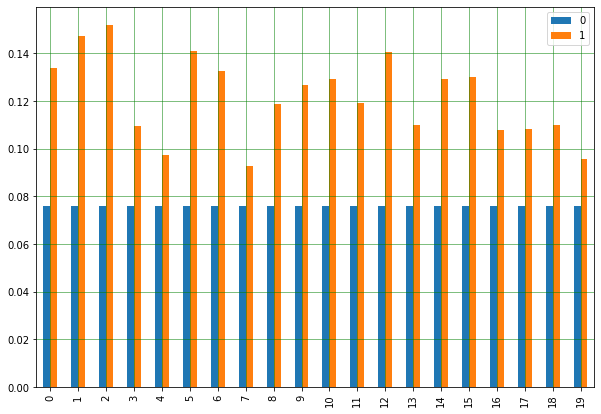

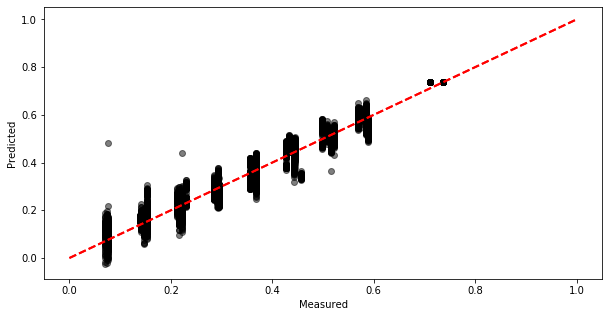

In [86]:
df1 = pd.DataFrame(actual_and_pred).head(20)

df1.plot(kind='bar',figsize=(10,7))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(10,5))

ax.plot([y_test.min(),y_test.max()],
        [y_test.min(), y_test.max()],
        '--r', linewidth=2)

ax.scatter(df[y_feature], predictions, color='black', alpha=0.5)

ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')

plt.show()

In [ ]:
The bar chart illustrates clearly the overestimation of the small plots

### Step 4 : Generate list of predictions on the test data

In [11]:
filename = os.path.join(os.path.dirname(os.getcwd()), 'data','interim','full_feature_test_data.csv')
test_df = pd.read_csv(filename)
test_predictions = predict_regclas_model(test_df, reduced_list, feature_list,ols2, rf)

In [12]:
pd.DataFrame(test_predictions).to_csv('predictions.csv')